The idea is to implement here an architecture similar to the one developed in "Datadriven wind turbine wake modeling via probabilistic Machine Learning":
- autoencoder trained on the output wake field
- MLP from input to latent space which is then plugged to the trained decoder to obtain the actual desired output

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random

from utils.metrics import MetricsLogger
from utils.data_loaders import get_wake_dataloaders
import utils.utils as uutils
import utils.data_utils as data_utils
import utils.plotting as plotting
from utils.evaluation import test_pytorch_model

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

In [31]:
class AutoEncoder(nn.Module):
    def __init__(self, layer_dimensions: list[int], num_cells: int, activation_function, flatten: bool = False):
        super(AutoEncoder, self).__init__()
        self.act_function = activation_function
        incr = sorted(layer_dimensions)
        decr = sorted(layer_dimensions, reverse=True)
        
        encoder_layers = self.__generate_encoder_layers(num_cells, decr)
        decoder_layers = self.__generate_decoder_layers(num_cells, incr)
        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)
    
    def __generate_encoder_layers(self, num_cells: int, decr_layers_units: list[int]):
        encoder_layers = []
        encoder_layers += [nn.Linear(num_cells, decr_layers_units[0]), self.act_function]
        for first, second in zip(decr_layers_units, decr_layers_units[1:]):
            encoder_layers += [nn.Linear(first, second), self.act_function] #TODO activate last layer?
        return encoder_layers

    def __generate_decoder_layers(self, num_cells: int, incr_layers_units: list[int]):
        decoder_layers = []
        for first, second in zip(incr_layers_units, incr_layers_units[1:]):
            decoder_layers += [nn.Linear(first, second), self.act_function]
        decoder_layers += [nn.Linear(incr_layers_units[-1], num_cells), self.act_function] #TODO activate last layer?
        return decoder_layers
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [32]:
# hyperparameters
BATCH_SIZE = 64
EPOCHS = 500
LR = 0.005
HIDDEN_LAYERS_UNITS = [20, 100, 500, 2000]
ACTIVATION_FUNCTION = nn.ReLU()

FACTORS_FOLDER = "discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01"
DATA_FOLDER = f"data/{FACTORS_FOLDER}/"
MODEL_NAME = f"autoencoders_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
CONSIDER_WS = True
COORDS_AS_INPUT = False # multivariate data
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f", batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nDevice: {DEVICE}")

Model name: autoencoders_layers20-100-500-2000_consider_ws
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/autoencoders_layers20-100-500-2000_consider_ws.pt
Model description: autoencoders_layers20-100-500-2000_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU , batch size 64, 500 epochs, lr=0.005)

Device: cpu


In [4]:
valid_dataloader = None
train_dataloader, valid_dataloader, test_dataloader = get_wake_dataloaders(DATA_FOLDER,
                                                          consider_ws=CONSIDER_WS,
                                                          coords_as_input=COORDS_AS_INPUT,
                                                          train_perc=0.6,
                                                          test_perc=0.2,
                                                          validation_perc=0.2,
                                                          batch_size=BATCH_SIZE)
len(train_dataloader), len(test_dataloader)

(129, 35)

In [5]:
for b in train_dataloader:
    print(b[0].shape, b[1].shape)
    break

input_space = train_dataloader.dataset.inputs.shape[1]
output_space = train_dataloader.dataset.outputs.shape[1]
print(f"{input_space=}\t{output_space=}")

torch.Size([64, 3]) torch.Size([64, 7168])
input_space=3	output_space=7168


In [ ]:
autoencoder = AutoEncoder(HIDDEN_LAYERS_UNITS, train_dataloader.dataset.num_cells, ACTIVATION_FUNCTION).to(DEVICE)
print(autoencoder)
optimizer = torch.optim.Adam(
    (p for p in autoencoder.parameters() if p.requires_grad), lr=LR
)
#optimizer = torch.optim.SGD(autoencoder.parameters(), lr=LR)#, weight_decay=WD)
loss_function = nn.MSELoss(reduction='mean')

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    autoencoder.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
        optimizer.zero_grad()
        reconstructed_wake_field = autoencoder(wake_field)
        tloss = loss_function(reconstructed_wake_field, wake_field)
        tloss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) TODO
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        autoencoder.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            wake_field = batch[1].to(DEVICE) # only considering the wake field (not the input variables)
            reconstructed_wake_field = autoencoder(wake_field)
            vloss = loss_function(reconstructed_wake_field, wake_field)

            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(autoencoder.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

AutoEncoder(
  (act_function): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=7168, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=20, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=7168, bias=True)
    (7): ReLU()
  )
)
Logging autoencoders_layers20-100-500-2000_consider_ws
Epoch 0 ->	Training loss=0.000669673843365727	Validation loss=0.0003817144156941636	
Epoch 1 ->	Training loss=0.0003772151761434295	Validation loss=0.00037931816292588005	
Epoch 2 ->	Training loss=0.0003760857012009982	

KeyboardInterrupt: 

# Second part: MLP from input to latent space which is then plugged to the decoder

For the training of this second part, there are two main options:
- to calculate the loss as the final difference between the reconstructed output and the ground truth output -> it may be unfair because it would evaluate also the capacity of the decoder to reconstruct the field from the latent space
- to calculate the loss on the latent space (output of this model and the output of the previously-trained encoder) -> it may be uncorrect because it would learn from the ground truth but from a latent space that is obtained from the trained encoder

In [33]:
# loading best autoencoder
autoencoder = AutoEncoder(HIDDEN_LAYERS_UNITS, train_dataloader.dataset.num_cells, ACTIVATION_FUNCTION).to(DEVICE)
autoencoder.load_state_dict(torch.load(BEST_MODEL_PATH))
autoencoder.eval()

bottleneck_space = min(HIDDEN_LAYERS_UNITS) # minimum of autoencoder hidden units
print(f"{bottleneck_space=}")
final_model_description = "Autoencoder description: " + MODEL_DESCRIPTION
autoencoder

bottleneck_space=20


AutoEncoder(
  (act_function): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=7168, out_features=2000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2000, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=20, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=2000, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2000, out_features=7168, bias=True)
    (7): ReLU()
  )
)

In [34]:
# new hyperparameters
HIDDEN_LAYERS_UNITS = [15, 50]
ACTIVATION_FUNCTION = nn.ReLU()
EPOCHS = 500
LR = 0.001

MODEL_NAME = f"aemlp_layers{'-'.join(str(lu) for lu in HIDDEN_LAYERS_UNITS)}"
BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"
if CONSIDER_WS:
    MODEL_NAME += "_consider_ws"
    BEST_MODEL_PATH = f"saved_models/{FACTORS_FOLDER}/{MODEL_NAME}.pt"\
        .replace("TIstep0.01_CTstep0.01", "reducedTI-CT")
print(f"Model name: {MODEL_NAME}")
print(f"Best model path: {BEST_MODEL_PATH}")

MODEL_DESCRIPTION = f"{MODEL_NAME}_{FACTORS_FOLDER}: act. func. {ACTIVATION_FUNCTION.__class__.__name__} " +\
    f"(not last layer), batch size {BATCH_SIZE}, {EPOCHS} epochs, lr={LR})"
print(f"Model description: {MODEL_DESCRIPTION}")
final_model_description += " --- MLP description: " + MODEL_DESCRIPTION

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{DEVICE=}")

Model name: aemlp_layers15-50_consider_ws
Best model path: saved_models/discr_factors_x2_30_y-2_2_step0.125_reducedTI-CT/aemlp_layers15-50_consider_ws.pt
Model description: aemlp_layers15-50_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
DEVICE=device(type='cpu')


In [35]:
class AE_MLP(nn.Module):
    def __init__(self, input_space, output_space) -> None:
        super(AE_MLP, self).__init__()
        layer_units = [input_space] + HIDDEN_LAYERS_UNITS
        layers = list()
        for first, second in zip(layer_units, layer_units[1:]):
            layers += [nn.Linear(first, second), ACTIVATION_FUNCTION]
        layers.append(nn.Linear(layer_units[-1], output_space)) # last layer not activated
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [ ]:
mlp = AE_MLP(input_space, bottleneck_space)

optimizer = torch.optim.Adam(
    (p for p in mlp.parameters() if p.requires_grad), lr=LR
)
loss_function = torch.nn.MSELoss() #TODO change ?

metrics_logger = MetricsLogger(name=MODEL_NAME)
best_vloss = 1_000_000.
for epoch in range(EPOCHS):
    '''TRAINING'''
    mlp.train(True)
    epoch_tloss = 0
    for batch in iter(train_dataloader):
        input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)
        optimizer.zero_grad()

        bottleneck_pred = mlp.forward(input_features)
        bottleneck_truth = autoencoder.encoder(wake_field)
        
        tloss = loss_function(bottleneck_pred, bottleneck_truth)
        tloss.backward()
        optimizer.step()

        epoch_tloss += tloss.item() * BATCH_SIZE

    avg_tloss = epoch_tloss / len(train_dataloader.sampler)
    metrics_logger.log_metric(epoch, 'Training loss', avg_tloss)

    '''VALIDATION'''
    if valid_dataloader:
        mlp.train(False)
        epoch_vloss = 0
        for batch in iter(valid_dataloader):
            input_features, wake_field = batch[0].to(DEVICE), batch[1].to(DEVICE)

            bottleneck_pred = mlp.forward(input_features)
            bottleneck_truth = autoencoder.encoder(wake_field)

            vloss = loss_function(bottleneck_pred, bottleneck_truth)
            epoch_vloss += vloss.item() * BATCH_SIZE

        avg_vloss = epoch_vloss / len(valid_dataloader.sampler)
        metrics_logger.log_metric(epoch, 'Validation loss', avg_vloss)
        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            torch.save(mlp.state_dict(), BEST_MODEL_PATH)

metrics_logger.plot_metrics_by_epoch()
metrics_logger.save_metrics()

# Testing

In [36]:
# loading best mlp
mlp = AE_MLP(input_space, bottleneck_space).to(DEVICE)
mlp.load_state_dict(torch.load(BEST_MODEL_PATH))
mlp.eval()

mlp

AE_MLP(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=15, bias=True)
    (1): ReLU()
    (2): Linear(in_features=15, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=20, bias=True)
  )
)

In [37]:
class FinalModel(nn.Module): #TODO change name
    def __init__(self, mlp: AE_MLP, autoencoder: AutoEncoder):
        super(FinalModel, self).__init__()
        self.mlp = mlp
        self.autoencoder = autoencoder

    def forward(self, x):
        x = self.mlp(x)
        x = self.autoencoder.decoder(x)
        return x


In [38]:
# loading best model
model = FinalModel(mlp, autoencoder).to(DEVICE)
model.eval()

test_pytorch_model(model, test_dataloader,
                   model_description=final_model_description,
                   save_results=False)

Test results for Autoencoder description: autoencoders_layers20-100-500-2000_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU , batch size 64, 500 epochs, lr=0.005) --- MLP description: aemlp_layers15-50_consider_ws_discr_factors_x2_30_y-2_2_step0.125_TIstep0.01_CTstep0.01: act. func. ReLU (not last layer), batch size 64, 500 epochs, lr=0.001)
r2_score=-1.1802391163426125
explained_variance_score=0.25591044059755014
mean_squared_error=0.00035731540992856026
mean_absolute_error=0.010279952548444271
median_absolute_error=0.008102518506348133
mean_absolute_percentage_error=3.5876686573028564
Prediction time=0.0002956432645971125s


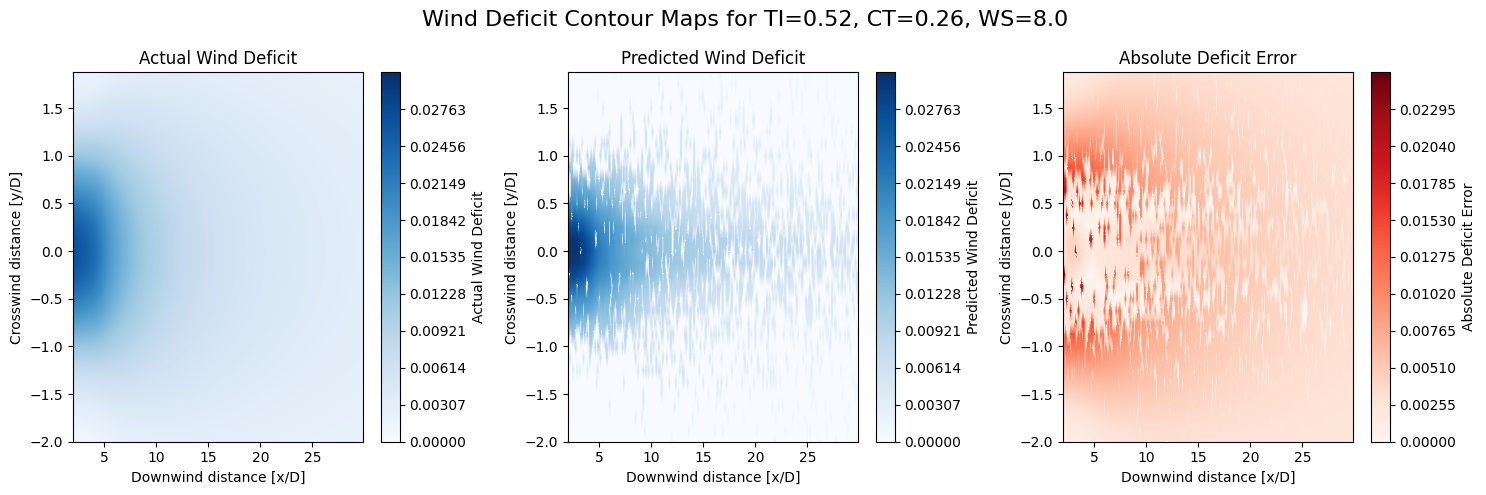

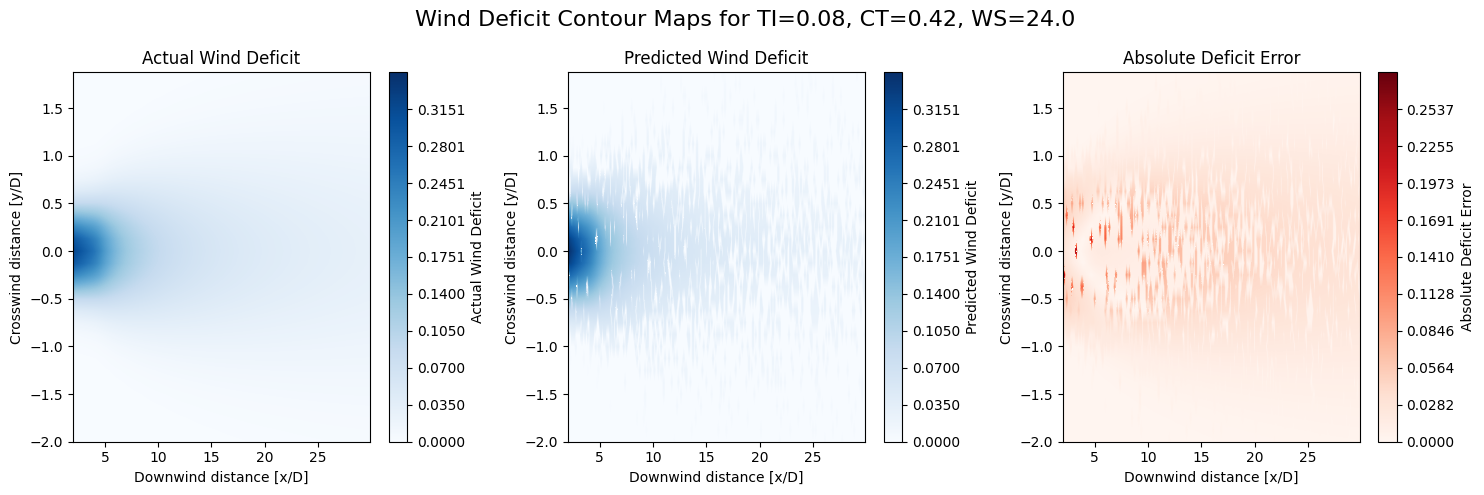

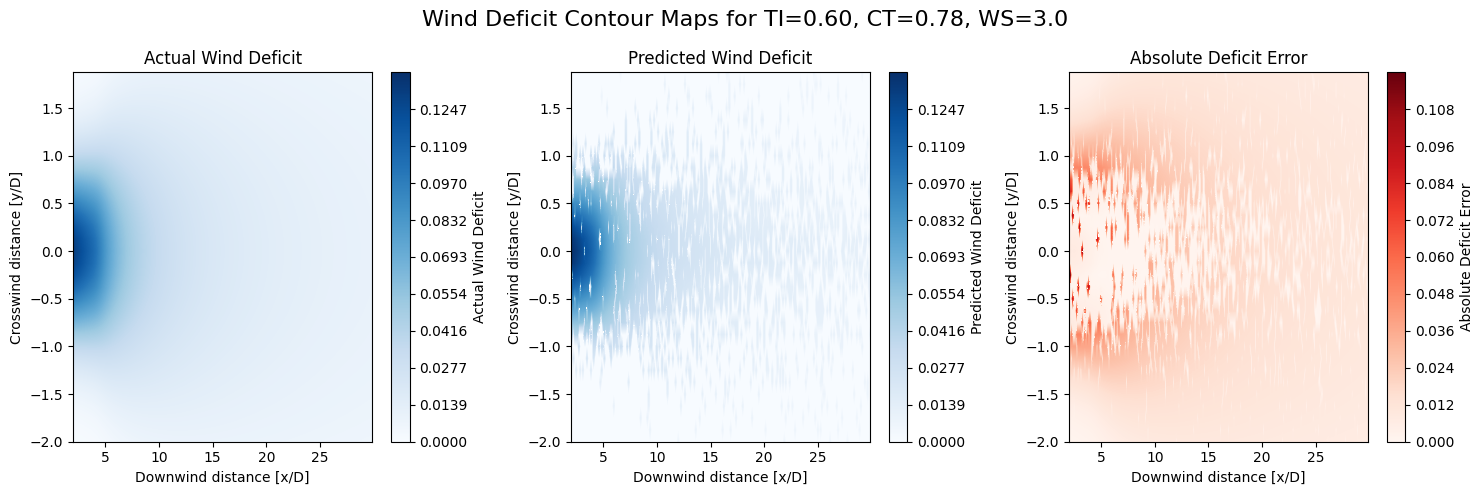

In [39]:
test_dataset = test_dataloader.dataset
indices = list(range(len(test_dataset)))
random.shuffle(indices)
with torch.no_grad():
    for idx in indices:
        ti, ct, ws, wake_field, predicted_wake_field = test_dataset.get_parameters_for_plotting_multivariate(model, idx)
        
        plotting.plot_maps(test_dataset.X_grid, test_dataset.Y_grid, wake_field, predicted_wake_field, ti, ct, ws, error_to_plot='absolute')